In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get the data for halves
def returnHalfData(ncols):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data for halves
def returnSquareData(squareSideLength):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateCenterSquareMask(squareSideLength))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateCenterSquareMask(squareSideLength))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get the data
def returnData():
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train, test


----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
---- Affine Estimator MSE ----
Train data: 0.080242
Test data: 0.109739


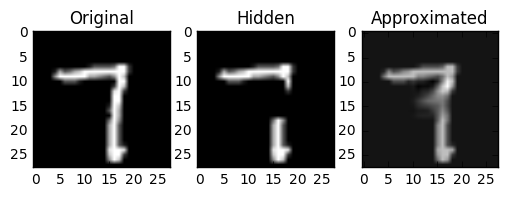

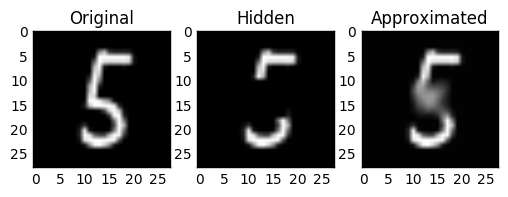

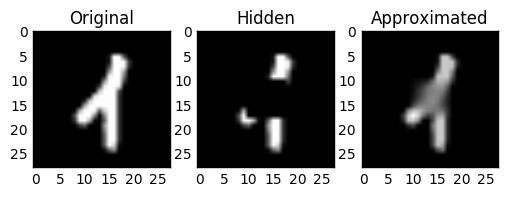

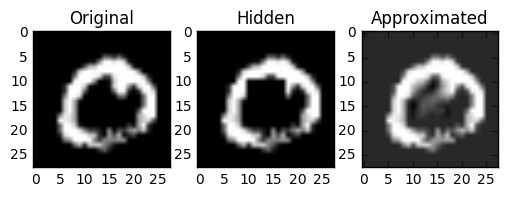

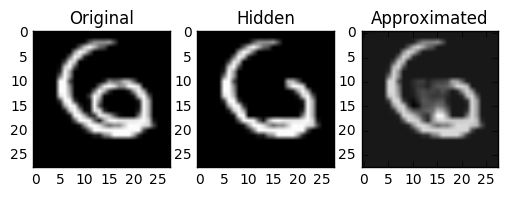

In [2]:
train, test = returnData()

squareSideLength = 8
train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSideLength)

u_x, u_y, cov_x, cov_yx = getStatistics(train, generateCenterSquareMask(squareSideLength))

def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

Ytrain_hat = mmseEstimator(Xtrain_hideCenter, u_x, u_y, cov_x, cov_yx)
Ytest_hat = mmseEstimator(Xtest_hideCenter, u_x, u_y, cov_x, cov_yx)

maskVec = generateCenterSquareMask(squareSideLength)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

approxImgVecs_train = np.zeros((train.shape[0], train.shape[1]))
approxImgVecs_test = np.zeros((test.shape[0], test.shape[1]))
approxImgVecs_train[x_idx, :] = Xtrain_hideCenter
approxImgVecs_train[y_idx, :] = Ytrain_hat
approxImgVecs_test[x_idx, :] = Xtest_hideCenter
approxImgVecs_test[y_idx, :] = Ytest_hat

for i in range(5):
    random = np.random.randint(0, 10000)    

    # original image
    original = train[:, random]
    originalImg = unpackcw(original, 28, 28)

    # hidden image
    hidden = train_hideCenter[:, random]
    hiddenImg = unpackcw(hidden, 28, 28)
    
    # approximated image
    approx = approxImgVecs_train[:, random]
    approxImg = unpackcw(approx, 28, 28)
    
    # plot
    plt.figure(i); 
    plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('Original')
    plt.subplot(1, 3, 2); plt.imshow(hiddenImg, cmap='gray'); plt.title('Hidden')
    plt.subplot(1, 3, 3); plt.imshow(approxImg, cmap='gray'); plt.title('Approximated')
    
# calculate the mse of the training and test sets using affine estimator
# this is only on the regenerated center
diff_train = Ytrain_hat - Ytrain_hideCenter
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = Ytest_hat - Ytest_hideCenter
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

In [5]:
# ----------------------------
#    Blanked to Original
# ----------------------------
predicted_train_pre = np.load('predictedTrain_square_8.npy')
predicted_test_pre = np.load('predictedTest_square_8.npy')

predicted_train = np.copy(predicted_train_pre)
predicted_train[x_idx] = Xtrain_hideCenter
predicted_test = np.copy(predicted_test_pre)
predicted_test[x_idx] = Xtest_hideCenter

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_pre
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_pre
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

#-------------------------
#  MSE for right half image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train[y_idx]
temp2 = test[y_idx]
temp3 = predicted_train[y_idx]
temp4 = predicted_test[y_idx]

diff_train = temp1 - temp3
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - temp4
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE


---- Generated Data MSE ----
Train data: 0.228478
Test data: 0.231482
---- Generated Data MSE ----
Train data: 0.021880
Test data: 0.053265


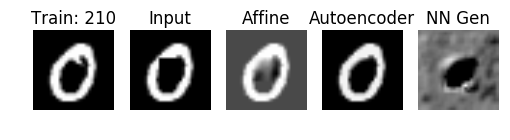

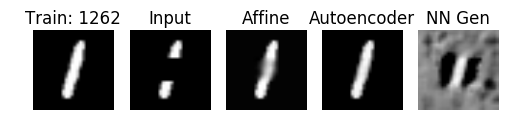

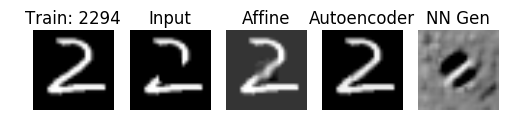

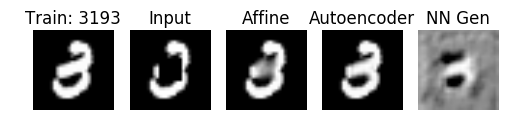

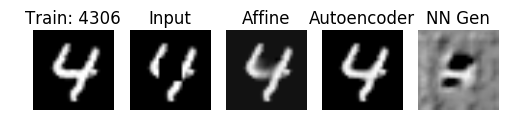

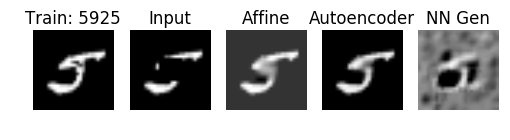

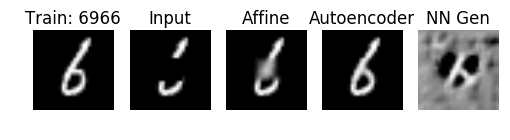

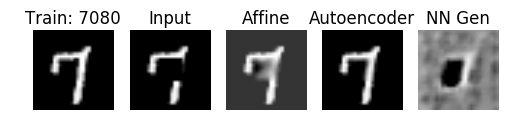

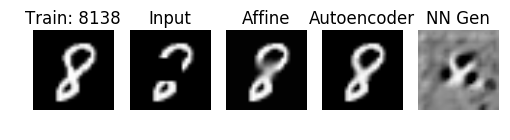

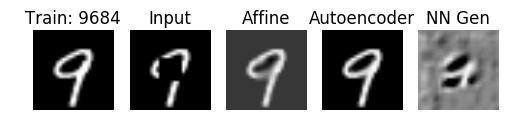

In [9]:
for i in range(10):  
    randomTrain = np.random.randint(i*1000, (i+1)*1000)
    
    origTrain = train[:, randomTrain]
    hiddenTrain = train_hideCenter[:, randomTrain]
    mmseTrain = approxImgVecs_train[:, randomTrain]
    nn_train = predicted_train[:, randomTrain]
    nn_train_generated = predicted_train_pre[:, randomTrain]
    
    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgHiddenTrain = unpackcw(hiddenTrain, 28, 28)
    imgApproxTrain = unpackcw(mmseTrain, 28, 28)
    imgNNTrain = unpackcw(nn_train, 28, 28)
    imgNNTrain_generated = unpackcw(nn_train_generated, 28, 28)
    
    plt.figure(i);
    plt.subplot(1, 5, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Train: %d' %randomTrain); plt.axis('off')
    plt.subplot(1, 5, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.title('Input'); plt.axis('off')
    plt.subplot(1, 5, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.title('Affine'); plt.axis('off')
    plt.subplot(1, 5, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
    plt.subplot(1, 5, 5); plt.imshow(imgNNTrain_generated, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
    #plt.savefig('Figs_train_square_24x24_%d_%d' %(randomTrain,i))

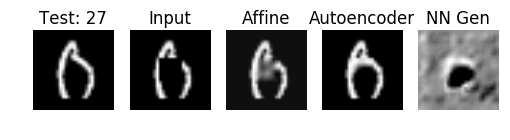

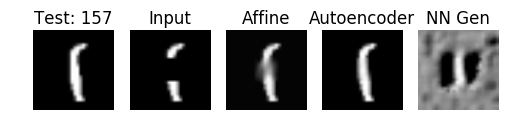

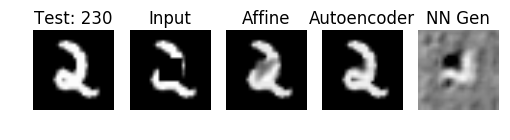

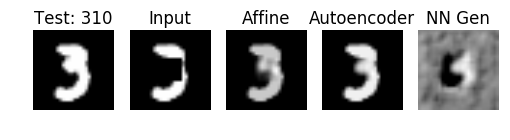

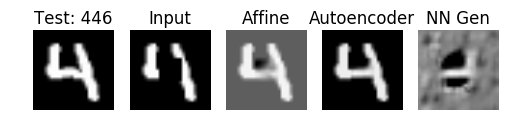

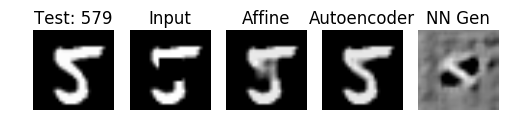

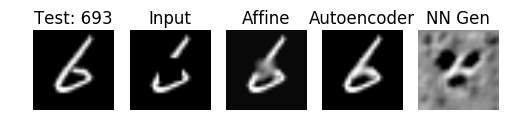

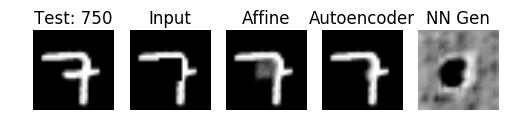

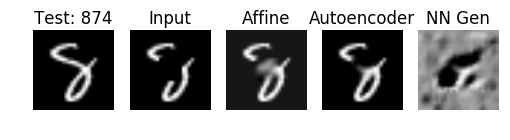

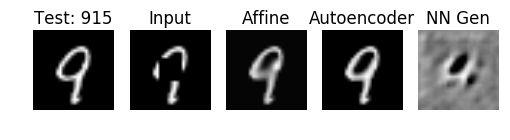

In [10]:
for i in range(10):  
    randomTest = np.random.randint(i*100, (i+1)*100)
    
    origTest = test[:, randomTest]
    hiddenTest = test_hideCenter[:, randomTest]
    mmseTest = approxImgVecs_test[:, randomTest]
    nn_test = predicted_test[:, randomTest]
    nn_test_generated = predicted_test_pre[:, randomTest]

    imgOrigTest = unpackcw(origTest, 28, 28)
    imgHiddenTest = unpackcw(hiddenTest, 28, 28)
    imgApproxTest = unpackcw(mmseTest, 28, 28)
    imgNNTest = unpackcw(nn_test, 28, 28)
    imgNNTest_gen = unpackcw(nn_test_generated, 28, 28)
    
    plt.figure(i);
    plt.subplot(1, 5, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Test: %d' %randomTest); plt.axis('off')
    plt.subplot(1, 5, 2); plt.imshow(imgHiddenTest, cmap='gray'); plt.title('Input'); plt.axis('off')
    plt.subplot(1, 5, 3); plt.imshow(imgApproxTest, cmap='gray'); plt.title('Affine'); plt.axis('off')
    plt.subplot(1, 5, 4); plt.imshow(imgNNTest, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
    plt.subplot(1, 5, 5); plt.imshow(imgNNTest_gen, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
    #plt.savefig('Figs_test_square_24x24_%d_%d' %(randomTest,i))

In [3]:
# ----------------------------
#    Other testing - Various MSE metrics (just generated or whole image lolz)
# ----------------------------
predicted_train = np.load('predictedTrain.npy')
predicted_test = np.load('predictedTest.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

#------------------------------------------
#  MSE for unknown portion of image
#------------------------------------------
maskVec = generateCenterSquareMask(8)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

hidden_predictedTrain, X_predictedTrain, Y_predictedTrain = hideData(predicted_train, maskVec)
hidden_predictedTest, X_predictedTest, Y_predictedTest = hideData(predicted_test, maskVec)

temp1 = train[y_idx]
temp2 = test[y_idx]

diff_train = temp1 - Y_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - Y_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE (Middle Image - Y) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

temp1 = train[x_idx]
temp2 = test[x_idx]

diff_train = temp1 - X_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - X_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)
testMSE2 = np.mean(np.multiply(diff_test, diff_test))
print '---- Generated Data MSE (Outside Image - X) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE
print '---- Either way of defining MSE works ----'
print testMSE
print testMSE2

---- Generated Data MSE ----
Train data: 0.014384
Test data: 0.015986
---- Generated Data MSE (Middle Image - Y) ----
Train data: 0.057725
Test data: 0.065758
---- Generated Data MSE (Outside Image - X) ----
Train data: 0.010531
Test data: 0.011562
---- Either way of defining MSE works ----
0.0115618266905
0.0115618266905


In [4]:
testSplit_X = np.zeros((10, Xtest_hideCenter.shape[0], Xtest_hideCenter.shape[1]/10))
testSplit_Y = np.zeros((10, Ytest_hideCenter.shape[0], Ytest_hideCenter.shape[1]/10))

testSplit_X_hat = np.zeros((10, X_predictedTest.shape[0], X_predictedTest.shape[1]/10))
testSplit_Y_hat = np.zeros((10, Y_predictedTest.shape[0], Y_predictedTest.shape[1]/10))

for i in range(10):
  for j in range(10):
    testSplit_X[i, :, j*10:(j+1)*10] = Xtest_hideCenter[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y[i, :, j*10:(j+1)*10] = Ytest_hideCenter[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_X_hat[i, :, j*10:(j+1)*10] = X_predictedTest[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y_hat[i, :, j*10:(j+1)*10] = Y_predictedTest[:, j*100+i*10:j*100+(i+1)*10]

In [5]:
temp = np.zeros(10)
for i in range(10):
    diff_Split = testSplit_Y_hat[i] - testSplit_Y[i]
    temp[i] = np.mean(np.multiply(diff_Split, diff_Split))
    
print temp
print np.mean(temp)
print np.std(temp)

[ 0.06386917  0.0671013   0.06814566  0.06640649  0.0661793   0.0638123
  0.06692971  0.06482716  0.06233799  0.06797259]
0.0657581665416
0.00185194491088
